In [10]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from matplotlib import pyplot
import matplotlib.pyplot as mp
import warnings



%matplotlib inline





In [11]:
month_data = pd.read_csv('month_Data.csv')

In [12]:
month_data.head()

,amt_per_trans,cost,month_num,monthly_spent,num_offers,offer_id,person_id,profit,profity,trans_offer,...,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant
0,0.0,0.0,3.0,0.0,1.0,10.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
1,0.0,0.0,3.0,0.0,1.0,10.0,3.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
2,0.0,0.0,3.0,0.0,1.0,10.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
3,0.0,0.0,3.0,0.0,1.0,10.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
4,0.0,0.0,3.0,0.0,1.0,10.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3


In [13]:
month_data['year'] = month_data['month_num'] //2
month_data['quarters'] = month_data['month_num']//4



In [14]:
def monthoffer(offerid, month_data, start_month=2,\
                                end_month=19):
    """
    DESCRIPTION:
        Creating subset of monthly data for the offer
    
    INPUTS:
        offerid - Offer id we want to analyze
        month_data - The monthly data set that we loaded above
        start_month - First month of the data
        end_month - Last month of the data
    
    OUTPUTS:
        month_data_new - subset of original dataset for offer id we want to analyze
    """

    for month_num in range(start_month,end_month+1):
        # get the current month's data
        month_data_sub = month_data[month_data['month_num']==month_num]
        month_data_sub= month_data_sub[(month_data_sub[offerid]==1) |\
                                    (month_data_sub['offer_id_10']==1)]
        # get individuals who received the offer during the month
        month_ind = month_data_sub[month_data_sub[offerid]==1].person_id.unique()
        if month_num == start_month:
            month_data_new=month_data_sub[month_data_sub['person_id'].isin(month_ind)]
        else:
            month_data_new_2 = month_data_sub[month_data_sub['person_id'].isin(month_ind)]
            month_data_new = pd.concat([month_data_new, month_data_new_2], axis=0)
    month_data_new.reset_index(inplace=True)
    return month_data_new

In [15]:
month_data_8 = monthoffer('offer_id_8', month_data)

In [16]:
month_data_8.head()

,index,amt_per_trans,cost,month_num,monthly_spent,num_offers,offer_id,person_id,profit,profity,...,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant,year,quarters
0,29331,0.00,0.0,5.0,0.00,1.0,8.0,1.0,0.00,0.0,...,0,0,0,1,0,0,0,2,2.0,1.0
1,29332,0.00,0.0,5.0,0.00,1.0,10.0,1.0,0.00,0.0,...,0,0,0,0,0,1,0,3,2.0,1.0
2,29364,0.00,0.0,5.0,0.00,1.0,8.0,19.0,0.00,0.0,...,0,0,0,1,0,0,0,2,2.0,1.0
3,29365,0.74,0.0,5.0,0.74,1.0,10.0,19.0,0.74,1.0,...,0,0,0,0,0,1,0,1,2.0,1.0
4,29402,0.00,0.0,5.0,0.00,1.0,8.0,40.0,0.00,0.0,...,0,0,0,1,0,0,0,2,2.0,1.0


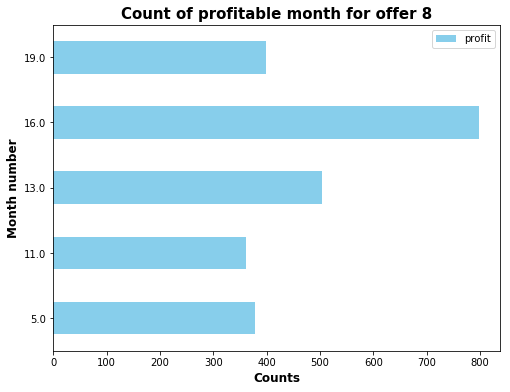

In [17]:
fig, ax = mp.subplots(figsize=(8,6));
month_data_8[month_data_8['offer_id_8']==1].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='barh',  color = 'skyblue',ax=ax);
ax.set_title("Count of profitable month for offer 8", fontsize=15, weight = 'bold')
ax.set_xlabel("Counts", fontsize=12 , weight = 'bold') ;
ax.set_ylabel("Month number", fontsize=12 , weight = 'bold');
ax.tick_params(axis='both', which='major', labelsize=10);

##https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller

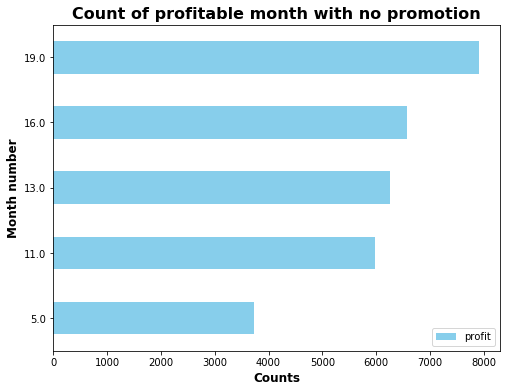

In [18]:
fig, ax = mp.subplots(figsize=(8,6));
month_data_8[month_data_8['offer_id_8']==0].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='barh', color = 'skyblue',ax=ax);
ax.set_title("Count of profitable month with no promotion", fontsize=16, weight = 'bold')
ax.set_xlabel("Counts", fontsize=12 , weight = 'bold') ;
ax.set_ylabel("Month number", fontsize=12 , weight = 'bold');
ax.tick_params(axis='both', which='major', labelsize=10);


In [19]:
month_data_8.month_num.value_counts().sort_index()

5.0     2526
11.0    2494
13.0    2500
16.0    2610
19.0    2486
Name: month_num, dtype: int64

In [20]:


train_offer_8 = month_data_8[month_data_8['month_num']<=13].reset_index(drop=True)
valid_offer_8 = month_data_8[month_data_8['month_num']==16].reset_index(drop=True)
test_offer_8 = month_data_8[month_data_8['month_num']==19].reset_index(drop=True)

#### Model

In [21]:
features = list(month_data.columns)
month_data.head()

,amt_per_trans,cost,month_num,monthly_spent,num_offers,offer_id,person_id,profit,profity,trans_offer,...,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant,year,quarters
0,0.0,0.0,3.0,0.0,1.0,10.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0
1,0.0,0.0,3.0,0.0,1.0,10.0,3.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0
2,0.0,0.0,3.0,0.0,1.0,10.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0
3,0.0,0.0,3.0,0.0,1.0,10.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0
4,0.0,0.0,3.0,0.0,1.0,10.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0


In [22]:
features =['amt_per_trans',
 'cost',
 'month_num',
 'monthly_spent',
 'num_offers',
 'profit',
 'profity',
 'trans_offer',
 'cum_monthly_spent_offer_id_0',
 'cum_trans_offer_offer_id_0',
 'cum_profit_offer_id_0',
 'cum_monthly_spent_offer_id_1',
 'cum_trans_offer_offer_id_1',
 'cum_profit_offer_id_1',
 'cum_monthly_spent_offer_id_2',
 'cum_trans_offer_offer_id_2',
 'cum_profit_offer_id_2',
 'cum_monthly_spent_offer_id_3',
 'cum_trans_offer_offer_id_3',
 'cum_profit_offer_id_3',
 'cum_monthly_spent_offer_id_4',
 'cum_trans_offer_offer_id_4',
 'cum_profit_offer_id_4',
 'cum_monthly_spent_offer_id_5',
 'cum_trans_offer_offer_id_5',
 'cum_profit_offer_id_5',
 'cum_monthly_spent_offer_id_6',
 'cum_trans_offer_offer_id_6',
 'cum_profit_offer_id_6',
 'cum_monthly_spent_offer_id_7',
 'cum_trans_offer_offer_id_7',
 'cum_profit_offer_id_7',
 'cum_monthly_spent_offer_id_8',
 'cum_trans_offer_offer_id_8',
 'cum_profit_offer_id_8',
 'cum_monthly_spent_offer_id_9',
 'cum_trans_offer_offer_id_9',
 'cum_profit_offer_id_9',
 'cum_monthly_spent_offer_id_10',
 'cum_trans_offer_offer_id_10',
 'cum_profit_offer_id_10',
 'cum_spent_per_trans_offer_offer_id_0',
 'cum_spent_per_trans_offer_offer_id_1',
 'cum_spent_per_trans_offer_offer_id_2',
 'cum_spent_per_trans_offer_offer_id_3',
 'cum_spent_per_trans_offer_offer_id_4',
 'cum_spent_per_trans_offer_offer_id_5',
 'cum_spent_per_trans_offer_offer_id_6',
 'cum_spent_per_trans_offer_offer_id_7',
 'cum_spent_per_trans_offer_offer_id_8',
 'cum_spent_per_trans_offer_offer_id_9',
 'cum_spent_per_trans_offer_offer_id_10',
 'cum_profit_per_trans_offer_offer_id_0',
 'cum_profit_per_trans_offer_offer_id_1',
 'cum_profit_per_trans_offer_offer_id_2',
 'cum_profit_per_trans_offer_offer_id_3',
 'cum_profit_per_trans_offer_offer_id_4',
 'cum_profit_per_trans_offer_offer_id_5',
 'cum_profit_per_trans_offer_offer_id_6',
 'cum_profit_per_trans_offer_offer_id_7',
 'cum_profit_per_trans_offer_offer_id_8',
 'cum_profit_per_trans_offer_offer_id_9',
 'cum_profit_per_trans_offer_offer_id_10',
 'cum_total_spend',
 'cum_trans',
 'cum_profit',
 'age',
 'income',
 'year_of_member',
 'month_of_member',
 'day_of_member',
 'gender_F',
 'gender_M',
 'gender_O',
 'year',
 'quarters']

In [23]:

X_train_offer_8 = train_offer_8[features]
X_valid_offer_8 = valid_offer_8[features]
X_test_offer_8 = test_offer_8[features]

Y_train_offer_8 = train_offer_8.profit
Y_valid_offer_8 = valid_offer_8.profit
Y_test_offer_8 = test_offer_8.profit

In [24]:
ss = StandardScaler()
X_train_scaled_offer_8 = pd.DataFrame(ss.fit_transform(X_train_offer_8))
X_train_scaled_offer_8.columns = features
X_train_scaled_offer_8.index = X_train_offer_8.index

X_valid_scaled_offer_8 = pd.DataFrame(ss.transform(X_valid_offer_8))
X_valid_scaled_offer_8.columns = features
X_valid_scaled_offer_8.index = X_valid_offer_8.index

X_test_scaled_offer_8 = pd.DataFrame(ss.transform(X_test_offer_8))
X_test_scaled_offer_8.columns = features
X_test_scaled_offer_8.index = X_test_offer_8.index

In [25]:
def PCAp(df, comp=None):
    '''
    DESCRIPTION:
       Purpose of this function is to transform the data into priciple components and provide back the data frame with PCA components

    INPUTS:
        df - data frame that we would need to transform
        comp - principle components

    OUTPUTS: 
        pca - the pca object created after fitting the data
        X_pca - the transformed X matrix with new number of components
    '''
    
    
    pca = PCA(comp)
    X_pca = pd.DataFrame(pca.fit_transform(df))
    if comp != None:
        X_pca.columns = ["pca_comp_n_" + str(i) for i in range(comp)]
    X_pca.index = df.index
    
    return pca, X_pca

## Same function was used in data processing 1

Text(0.5,1,'Explained Variance vs number of Principal Component')

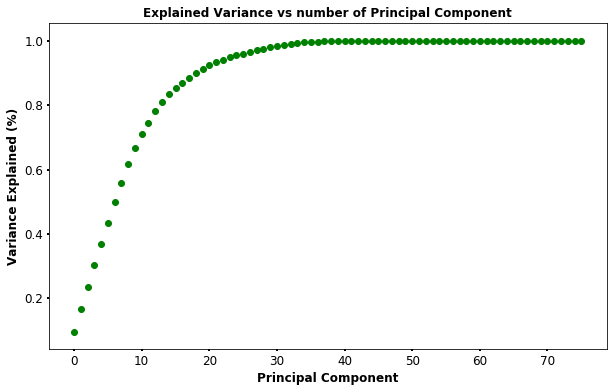

In [26]:
pca, X_train_pca_offer_8 = PCAp(X_train_scaled_offer_8, comp=None)

val = pca.explained_variance_ratio_

ind = np.arange(len(val))

val = val [:len(val)]
mp.figure(figsize=(10,6))
ax = mp.subplot(111)
    # Create array of cumulative variance explained for each n^th component
cumulative_values = np.cumsum(val)
    
# Plot line chart of cumulative variance explained vs number of components
ax.scatter(ind, cumulative_values, color = 'green')
ax.xaxis.set_tick_params(width=2, length=2, labelsize = '12')
ax.yaxis.set_tick_params(width=2, length=2, labelsize = '12')
ax.set_xlabel("Principal Component", fontsize = 12, weight = 'bold')
ax.set_ylabel("Variance Explained (%)", fontsize = 12, weight = 'bold')
mp.title('Explained Variance vs number of Principal Component', fontsize = 12, weight = 'bold')
    

##### n comp = 30 should satisfy

In [27]:
n_components = 30
values = pca.explained_variance_ratio_
cumulative_values = np.cumsum(values)
print("With {} components, {:.4f}% of the variance is explained".format(n_components, cumulative_values[n_components -1]*100))

With 30 components, 98.0685% of the variance is explained


In [28]:
comp = 30
pca, X_train_pca_offer_8 = PCAp(X_train_scaled_offer_8, comp=comp)

X_train_pca_offer_8.head()

,pca_comp_n_0,pca_comp_n_1,pca_comp_n_2,pca_comp_n_3,pca_comp_n_4,pca_comp_n_5,pca_comp_n_6,pca_comp_n_7,pca_comp_n_8,pca_comp_n_9,...,pca_comp_n_20,pca_comp_n_21,pca_comp_n_22,pca_comp_n_23,pca_comp_n_24,pca_comp_n_25,pca_comp_n_26,pca_comp_n_27,pca_comp_n_28,pca_comp_n_29
0,-2.786678,0.096739,0.078167,0.033152,-0.123788,0.045917,-0.086567,-0.383118,0.181195,-0.451875,...,0.173240,0.332578,-0.175746,0.057472,-0.033882,-0.113654,0.076982,-0.064074,-0.195786,0.211148
1,-2.786678,0.096739,0.078167,0.033152,-0.123788,0.045917,-0.086567,-0.383118,0.181195,-0.451875,...,0.173240,0.332578,-0.175746,0.057472,-0.033882,-0.113654,0.076982,-0.064074,-0.195786,0.211148
2,-2.742537,0.092930,0.039666,0.053165,-0.121774,0.049584,-0.076125,-0.391068,0.160800,-0.475794,...,0.211516,0.350911,-0.334052,0.155948,0.022141,-0.171152,0.073795,-0.070017,-0.176660,0.217257
3,-2.434274,0.008368,-0.016648,0.012277,-0.097194,0.184601,-0.036270,-0.180196,0.055341,1.367195,...,-1.057365,0.437209,-0.466433,0.277386,-0.020311,-0.207240,0.061000,-0.127009,-0.163076,0.235284
4,-2.361439,0.070452,0.108783,0.069780,-0.097453,0.087100,-0.041724,-0.324740,0.226983,-0.339785,...,0.078109,0.323620,-0.208805,0.035150,-0.043674,0.103953,-0.023528,-0.001986,0.058280,-0.217739


In [29]:
X_valid_pca_offer_8 = pd.DataFrame(pca.transform(X_valid_scaled_offer_8))
X_valid_pca_offer_8.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_valid_pca_offer_8.index = X_valid_scaled_offer_8.index

X_test_pca_offer_8 = pd.DataFrame(pca.transform(X_test_scaled_offer_8))
X_test_pca_offer_8.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_test_pca_offer_8.index = X_test_scaled_offer_8.index

In [31]:
train_ind_offer_8 = train_offer_8['offer_id_8']
valid_ind_offer_8 = valid_offer_8['offer_id_8']
test_ind_offer_8 = test_offer_8['offer_id_8']

X_train_pca_offer_8 = pd.concat([X_train_pca_offer_8, train_ind_offer_8], axis=1)
X_valid_pca_offer_8 = pd.concat([X_valid_pca_offer_8, valid_ind_offer_8], axis=1)
X_test_pca_offer_8 = pd.concat([X_test_pca_offer_8, test_ind_offer_8], axis=1)